# HandsOn-03 Tomographic Reconstruction

In this tutorial we limit the discussion to recovering the changes (i.e. not the iterative method), and use a simple scalar regularizer. Specifically, consider the linearized problem,
$$
\mathbf{y}=\mathbf{Ax}+\mathbf{\epsilon}
$$
We aim to estimate $x$ from $y$ by solving,
$$
\mathbf{\hat{x}}=\arg\max_\mathbf{x}||\mathbf{y}-\mathbf{Ax}||^2+\alpha||\mathbf{x}||^2
$$
where $\alpha$ is the regularizer.

You will experiment with and learn
- how voxel size affects the reconstruction
- how the number of measurements affects the reconstruction
- how the regularizer affects the reconstruction

We will use the 2D example for this tutorial.

In [1]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load mesh
mesh = ff.base.stndmesh()
mesh.from_file('../meshes/standard/circle2000_86_stnd')

Fixed sources
Sources integration functions loaded
Fixed detectors
Detectors integration functions loaded


In [3]:
# define the grid
xgrid = np.arange(-45., 45, 2)
ygrid = np.arange(-45., 45, 2)
mesh.gen_intmat(xgrid, ygrid)
# calculate the CW Jacobian for log amplitude
J = mesh.jacobian()[0]

Calculating direct field...
Calculating adjoint field...
Integrating...


## The Jacobian

Before stepping into reconstruction, let's first have a look at the Jacobian matrix, and plot it in the banana form.

First have a look at the size of it.

In [5]:
print(J.shape)

(240, 2025)


That is, number of channels (as defined by mesh.link) by number of voxels (as defined by xgrid and ygrid). If we reshape one of the rows into a 2D grid, we will end up with the banana of the corresponding channel. Let's try that (gotcha: the reshaping is done in the Fortran order, to be consistent with the Matlab version - be careful there)

In [6]:
print('The channels: [source_idx, detector_idx, active_or_not]')
print(mesh.link[2,:])
print(mesh.link[6,:])

fig, (ax1, ax2) = plt.subplots(1,2)
plt.set_cmap('hot')
h1 = ax1.imshow(np.abs(J[2,:].reshape((45,45),order='F')), origin='lower')
ax1.set_title('Jacobian, channel 3') # <- because python uses indexing, we are looking at the 3rd channel
fig.colorbar(h1, fraction=0.046, pad=0.04)

h2 = ax2.imshow(np.abs(J[6,:].reshape((45,45),order='F')), origin='lower')
ax2.set_title('Jacobian, channel 7')
fig.colorbar(h2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

The channels: [source_idx, detector_idx, active_or_not]
[1 4 1]
[1 8 1]


Recall from the lecture: the Jacobian is also called the sensitivity matrix. Effectively, the value at each voxel represents the total sensitivity in the area/volume it covers. This suggests two things:
- if the voxels become larger, their values should also become larger, because they cover more area/volume now, and
- regardless of the grid resolution (voxel size, however you like to call it), the summed value (per channel) should be the same, because the total sensitivity should not change.

Let's have a look at the total sensitivity at each channel. They are negative because when absorption coefficients increase, light intensities decrease.

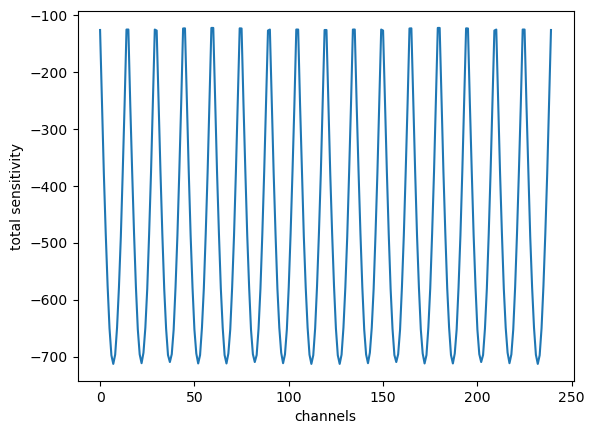

In [7]:
sensitivity = np.sum(J, axis=1)
plt.plot(sensitivity)
plt.xlabel('channels')
plt.ylabel('total sensitivity')
plt.show()

### Exercise 1

Please recalculate the Jacobian matrix using different grid resolutions, and observe
- how the plotted bananas change
- whether the total sensitivity per channel remain constant

Here is a start.

In [ ]:
mesh2 = ff.base.stndmesh()
mesh2.from_file('../meshes/standard/circle2000_86_stnd')
# define the grid
xgrid = np.arange(-45., 45, 1)  # <- notice this number 1: this is the resolution. it was previously 2
ygrid = np.arange(-45., 45, 1)  # <- and here as well
mesh2.gen_intmat(xgrid, ygrid)
# calculate the CW Jacobian for log amplitude
J2 = mesh2.jacobian()[0]

fig, (ax1, ax2) = plt.subplots(1,2)
plt.set_cmap('hot')
h1 = ax1.imshow(np.abs(J2[2,:].reshape((ygrid.size, xgrid.size),order='F')), origin='lower')
ax1.set_title('Jacobian, channel 3') # <- because python uses indexing, we are looking at the 3rd channel
fig.colorbar(h1, fraction=0.046, pad=0.04)

h2 = ax2.imshow(np.abs(J2[6,:].reshape((ygrid.size, xgrid.size),order='F')), origin='lower')
ax2.set_title('Jacobian, channel 7')
fig.colorbar(h2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

sensitivity2 = np.sum(J2, axis=1)
plt.plot(sensitivity2)
plt.xlabel('channels')
plt.ylabel('total sensitivity')
plt.show()

## Reconstruction

Now let's add an anomaly, and calculated the log amplitude change.

In [30]:
# Let's reload the meshes, just in case
mesh = ff.base.stndmesh()
mesh.from_file('../meshes/standard/circle2000_86_stnd')
# define the grid
xgrid = np.arange(-45., 45, 2)
ygrid = np.arange(-45., 45, 2)
mesh.gen_intmat(xgrid, ygrid)
# calculate the Jacobian
J = mesh.jacobian()[0]

mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)
# add anomaly: a 1cm-radius disk centered at (15,15)
center = np.array([15., 15])
idx = np.nonzero(np.linalg.norm(mesh.nodes - center, axis=1)<10)[0] # indices of the nodes within the disk
# give it a 5% mua increase
mesh2.change_prop(idx, [mesh.mua[0]*1.05, mesh.mus[0], mesh.ri[0]])
# calculate data
data1 = mesh.femdata(0)[0]
data2 = mesh2.femdata(0)[0]
# now the optical density change
dOD = np.log(data2.amplitude) - np.log(data1.amplitude)
# add some noise: iid gaussian with std being 5% of the max
dOD += np.random.randn(dOD.size)*0.05*dOD.max()

Fixed sources
Sources integration functions loaded
Fixed detectors
Detectors integration functions loaded
Calculating direct field...
Calculating adjoint field...
Integrating...


Now we can do the reconstruction. Conveniently, NIRFASTer provides a simple Tikhonov regularization function to do exactly that. The syntax is (remember that here we only use scalar regularizers),

recon = ff.inverse.tikhonov(jacobian, regularizer, dOD)

<Figure size 640x480 with 0 Axes>

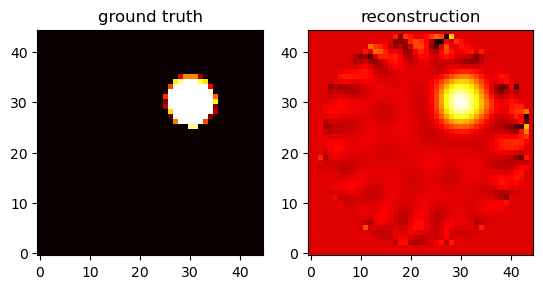

In [31]:
# reconstruction
dmua_recon = ff.inverse.tikhonov(J, 0.1, dOD)
# have a look
dmua_truth = np.reshape(mesh.vol.mesh2grid @ (mesh2.mua-mesh.mua), (ygrid.size, xgrid.size), order='F')

plt.set_cmap('hot')
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(dmua_truth, origin='lower')
ax1.set_title('ground truth')

ax2.imshow(dmua_recon.reshape((ygrid.size, xgrid.size), order='F'), origin='lower')
ax2.set_title('reconstruction')
plt.show()

### Exercise 2

Notice that in the example, we set the regularizer to 0.1, but this may or may not be optimal. In this exercise, please vary the regularizer (don't be afraid to make dramatic changes), and observe how it affects the reconstruction result.

Now increase the amount of noise - how would that change your choice of regularizer?

### Exercise 3

Now please vary the grid resolution (that is, how xgrid and ygrid are defined) and repeat the whole reconstruction process. Observe how the grid resolution affects the reconstruction result, and how that may affect the choice of regularizer.

## Dense vs coarse measurement

Here we explore how the number of measurements can affect the result of reconstruction, and understand why it is often desirable to record with high density.

In the mesh we have been using, there are 16 sources and 16 detectors, forming 240 channels. Let's have a look at their locations: red dots are sources and blue dots are detectors.

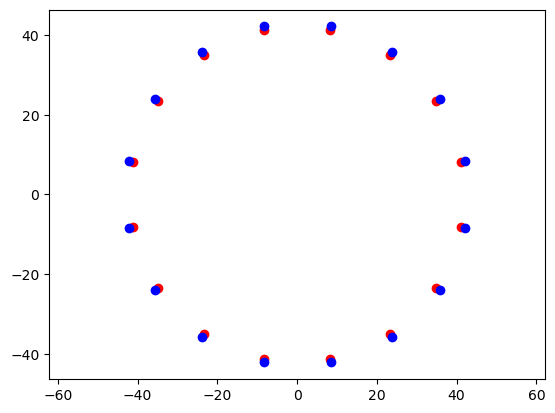

In [34]:
plt.scatter(mesh.source.coord[:,0], mesh.source.coord[:,1], color='r')
plt.scatter(mesh.meas.coord[:,0], mesh.meas.coord[:,1], color='b')
plt.axis('equal')
plt.show()

Now let's repeat the reconstruction part using fewer measurements, and see what it looks like. Conveniently, the meshes are already prepared for you in this folder: `circle_8x8` and `circle_4x4` and as the names suggest, they have 8 sources and 8 detectors, and 4 sources and 4 detectors, respectively. The mesh itself is exactly the same.

Let's load the 8x8 mesh and look at the locations of the optodes.

Sources integration functions loaded
Detectors integration functions loaded


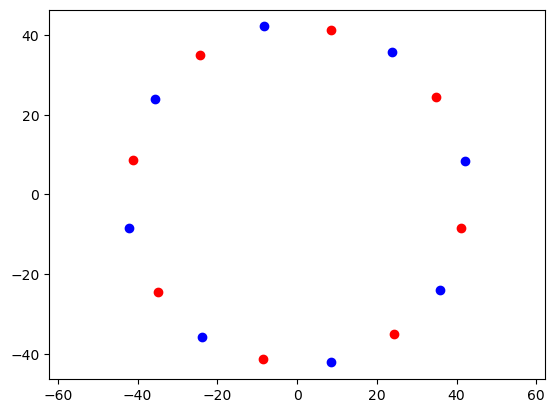

In [39]:
mesh = ff.base.stndmesh()
mesh.from_file('circle_8x8')

plt.scatter(mesh.source.coord[:,0], mesh.source.coord[:,1], color='r')
plt.scatter(mesh.meas.coord[:,0], mesh.meas.coord[:,1], color='b')
plt.axis('equal')
plt.show()

### Exercise 4

Please repeat the whole reconstruction simulation, play with the regularization to have the best possible reconstruction. Is it possible to make the result as nice as using the 16x16 measurement? 

In [ ]:
# calculate the jacobian

# add an anomaly and simulate the data

# reconstruct

# plot the results

### Further reading

As you have just seen, choosing a good regularizer is both important and tricky. It is also very common to use a non-scalar regularizer for more fine-grained control. In brain imaging, a good choice used by the NeuroDOT team can be found in Section II.E of [this paper](https://doi.org/10.1063/1.5086809).

One way (still heuristic, but very effective) to determine the optimal choice of $\alpha$ is called the "L-curve" method, as detailed [here](https://www.sintef.no/globalassets/project/evitameeting/2005/lcurve.pdf)

From a Bayesian perspective, a very interesting method to estimate the optimal regularizer from data is restricted maximum likelihood (ReML), as detailed [here](https://doi.org/10.1364/boe.1.001084)